# Use Case 3: Lead Scoring and Segmentation

Code authored by: Shaw Talebi

Video link: https://youtu.be/3JsgtpX_rpU <br>
Blog link: https://towardsdatascience.com/3-ai-use-cases-that-are-not-a-chatbot-f4f328a2707a

### import

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

### load data

In [2]:
# import resumes with embeddings
df = pl.read_csv('data/resumes_augemented_structured.csv')

In [3]:
# import outreach data
df_outreach = pl.read_csv('data/outreach.csv')

In [4]:
# join data
df = df.join(df_outreach, on="Name")

# drop duplicates
df = df.unique("Name")

In [5]:
# replace name with number for privacy
df = df.with_columns(pl.Series(name="Name", values=list(range(len(df)))))

### data prep

In [6]:
# define predictor and target variable names
X_names = [varname for varname in df.columns if "Embedding" in varname] + ["exp_level"]
y_name = "Responded"

# create predictor and target dfs
X = df[X_names]
y = df[y_name]

### Dimensionality Reduction

In [7]:
clf = RandomForestClassifier(random_state=0, n_estimators=2500, max_depth=4)
clf = clf.fit(X, y)

In [8]:
rf_auc_val = roc_auc_score(y, clf.predict_proba(X)[:,1])
rf_auc_val

1.0

In [9]:
feature_importances = pl.DataFrame({"Varname": X_names, "Importance":clf.feature_importances_})
feature_importances_sorted = feature_importances.sort(by="Importance", descending=True)
feature_importances_sorted

Varname,Importance
str,f64
"""Embedding-522""",0.007673
"""Embedding-6""",0.007626
"""Embedding-590""",0.006787
"""Embedding-343""",0.006409
"""Embedding-513""",0.006321
…,…
"""Embedding-368""",0.00028
"""Embedding-114""",0.000271
"""Embedding-187""",0.000266


### Train Yes and No Models

In [10]:
# create df consisting of leads that responded
df_responded = df.filter(pl.col("Responded"))
df_responded = df_responded.with_columns((pl.col("Yes/No") == "Yes").alias("Yes")).fill_null(False)
df_responded = df_responded.with_columns((pl.col("Yes/No") == "No").alias("No")).fill_null(False)

In [11]:
# train models to predict "yes" and "no" responses
clf_list = []
y_name_list = ["Yes", "No"]
num_vars = 75

train_auc_list = []
test_auc_list = []

feature_names = list(feature_importances_sorted["Varname"][:num_vars])

for y_name in y_name_list:
    
    # create predictor and target dfs
    X = df_responded[X_names]
    y = df_responded[y_name]
    
    # # create train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # train LR model with top n most important features
    clf = LogisticRegression(random_state=0, solver='newton-cg',class_weight='balanced').fit(X_train[feature_names], y_train)

    # store LR model and performance in list
    clf_list.append(clf)
    train_auc_list.append(roc_auc_score(y_train, clf.predict_proba(X_train[feature_names])[:,1]))
    test_auc_list.append(roc_auc_score(y_test, clf.predict_proba(X_test[feature_names])[:,1]))

In [12]:
print("Train AUC:", train_auc_list)
print("Test AUC:", test_auc_list)

Train AUC: [0.8722109533468559, 0.9362745098039216]
Test AUC: [0.5454545454545454, 0.7428571428571429]


### Apply model to entire dataset

In [13]:
yes_score = clf_list[0].predict_proba(df[feature_names])[:,1]
no_score = clf_list[1].predict_proba(df[feature_names])[:,1]

In [14]:
# add scores to original df
df = df.with_columns(pl.Series(name="Yes_score", values=yes_score))
df = df.with_columns(pl.Series(name="No_score", values=no_score))
df = df.with_columns(pl.Series(name="Score", values=yes_score-no_score))

# add yes and no columns to original df
df = df.with_columns((pl.col("Yes/No") == "Yes").alias("Yes"))
df = df.with_columns((pl.col("Yes/No") == "No").alias("No"))

### Score Analysis

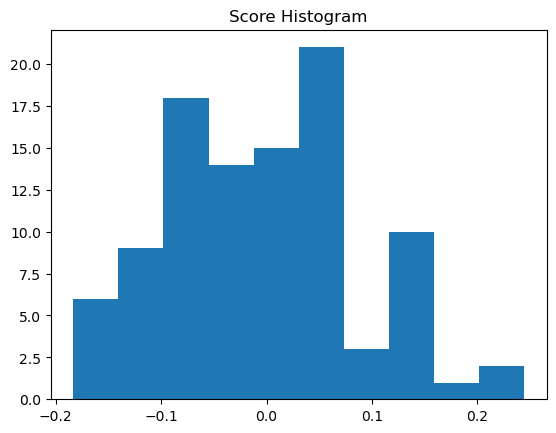

In [15]:
plt.hist(df["Score"])
plt.title("Score Histogram")
plt.show()

In [16]:
pl.Config(tbl_rows=15)
df.group_by("Role").agg([pl.len(), pl.col("Score").mean(), pl.col("Yes_score").mean(), pl.col("No_score").mean()]).sort(by="Score", descending=True)

Role,len,Score,Yes_score,No_score
str,u32,f64,f64,f64
"""IT Professional""",10,0.09905,0.520006,0.420956
"""Data Architect""",1,0.080062,0.506225,0.426162
"""Consultant""",10,0.071975,0.524281,0.452306
"""Data Manager""",2,0.021647,0.4643,0.442652
"""Data Analyst""",18,0.019786,0.484933,0.465146
"""Data Leader""",2,0.010137,0.467334,0.457198
"""SWE""",5,0.007902,0.48179,0.473888
"""Data Engineer""",6,-0.005887,0.466307,0.472194
"""Web Dev""",5,-0.034504,0.467486,0.50199


In [33]:
df.group_by("exp_level").agg([pl.len(), pl.col("Score").mean(), pl.col("Yes_score").mean(), pl.col("No_score").mean()]).sort(by="Score", descending=True)

exp_level,len,Score,Yes_score,No_score
i64,u32,f64,f64,f64
1,4,0.034944,0.492176,0.457231
3,50,0.002042,0.479409,0.477367
4,13,-0.004542,0.481412,0.485954
5,18,-0.004927,0.478864,0.483791
2,14,-0.02913,0.465266,0.494396


### Customer Segments

In [17]:
# add customer segments to df
df = df.with_columns((pl.col("Score").qcut([0.2, 0.9], labels=["C", "B", "A"])).alias("Score_segment"))

In [18]:
df.group_by("Score_segment").agg([pl.len(), pl.col("Score").mean(), pl.col("Yes_score").mean(), pl.col("No_score").mean()]).sort(by="Score", descending=True)

Score_segment,len,Score,Yes_score,No_score
cat,u32,f64,f64,f64
"""A""",10,0.163941,0.554968,0.391026
"""B""",69,0.007075,0.4826,0.475525
"""C""",20,-0.122064,0.424084,0.546148


In [19]:
df_scores = df[["Name", "Role", "Score", "Score_segment", "Yes_score", "No_score", "Responded", "Yes", "No"]].sort(by="Score", descending=True)
df_scores

Name,Role,Score,Score_segment,Yes_score,No_score,Responded,Yes,No
i64,str,f64,cat,f64,f64,bool,bool,bool
6,"""Consultant""",0.244367,"""A""",0.58384,0.339473,true,true,false
1,"""Data Analyst""",0.207496,"""A""",0.622144,0.414648,true,true,false
77,"""Consultant""",0.191983,"""A""",0.597789,0.405806,true,null,null
49,"""IT Professional""",0.157816,"""A""",0.570199,0.412384,true,true,false
85,"""IT Professional""",0.153249,"""A""",0.558596,0.405347,true,true,false
64,"""Data Scientist""",0.149413,"""A""",0.551859,0.402446,false,null,null
23,"""IT Professional""",0.144596,"""A""",0.560381,0.415786,true,true,false
55,"""IT Professional""",0.136802,"""A""",0.508633,0.371831,false,null,null
…,…,…,…,…,…,…,…,…


In [20]:
# write data to file
df_scores.write_csv('data/lead_scores.csv')